<h1><center>ACCESS-NRI Workshop 2023</center></h1>
<h2><center>Introduction to ESMValTool</center></h2>


<table>
<tbody>
  <tr>
<td><img width=400 src="https://www.access-nri.org.au/wp-content/themes/accessnri/images/logos/access_logo_rgb.svg"></td>
    <td><img width=400 src="https://docs.esmvaltool.org/en/v2.5.0/_static/ESMValTool-logo-2.png"></td>
  </tr>
</tbody>
</table>

[ESMValTool](https://github.com/ESMValGroup/ESMValTool) is a library of climate data analysis workflows ("recipes") and [ESMValCore](https://github.com/ESMValGroup/ESMValCore) is the tool that can run those recipes. With ESMValTool, it is easy to reproduce already published analyses as well as develop new ones. A useful feature is that you can directly access all the output (data, images, etc) and further process them in the notebook. ESMValTool has specifically been designed to analyse data produced as part of the [Climate Model Intercomparison Project](https://www.wcrp-climate.org/wgcm-cmip/wgcm-cmip6), though it also [supports many observational and reanalysis datasets](https://docs.esmvaltool.org/en/latest/input.html#supported-datasets-for-which-a-cmorizer-script-is-available). It is used extensively to (re)produce the analyses in the [IPCC Assessment Reports](https://www.ipcc.ch/assessment-report/ar6/).

<table>
<tbody>
  <tr>
    <td><img width=200 src="https://jupyter.org/assets/homepage/hublogo.svg"></td>
    <td><img width=200 src="https://zenodo.org/api/files/00000000-0000-0000-0000-000000000000/is-enes3/logo.png"></td>
    <td><img width=200 src="https://www.smhi.se/polopoly_fs/1.135796.1527766089!/image/LoggaEUCP.png_gen/derivatives/Original_366px/image/LoggaEUCP.png"></td>
  </tr>
  <tr>
    <td> <img width=200 src="https://www.dkrz.de/@@site-logo/dkrz.svg"></td>
    <td><img width=200 src="https://upload.wikimedia.org/wikipedia/commons/8/85/SMHI_Logo.svg"></td>
    <td><img width=200 src="https://www.dtls.nl/wp-content/uploads/2015/03/NleSc.png"></td>
    <td></td>
  </tr>
</tbody>
</table>

<div class="alert alert-block alert-info"> <b>The Following tutorial was originally presented at the European Geosciences Union 2022. Original files can be retrieve <a href="https://github.com/ESMValGroup/EGU22-short-course">here</a></b></div>



In [1]:
import warnings
warnings.filterwarnings('ignore')

# Import the tool
import esmvalcore.experimental as esmvaltool

# Import tools for plotting
import matplotlib.pyplot as plt
import iris.quickplot

## Working with ESMValTool recipes

To see a list of [all the available ESMValTool recipes](https://docs.esmvaltool.org/en/latest/recipes/index.html) (only the first 10 are shown here):

In [2]:
all_recipes = esmvaltool.get_all_recipes()
all_recipes[:10]

[Recipe('Recipe albedolandcover'),
 Recipe('Recipe anav13jclim'),
 Recipe('Recipe arctic ocean'),
 Recipe('Recipe autoassess landsurface permafrost'),
 Recipe('Recipe autoassess landsurface soilmoisture'),
 Recipe('Recipe autoassess landsurface surfrad'),
 Recipe('Recipe autoassess stratosphere'),
 Recipe('Recipe capacity factor'),
 Recipe('Recipe carvalhais14nat'),
 Recipe('Recipe climate change hotspot')]

In this notebook, we'll just run the Climate model Weighting by Independence and Performance (ClimWIP) basic recipe.
Documentation for this recipe is available [here](https://docs.esmvaltool.org/en/latest/recipes/recipe_climwip.html).

In [3]:
climwip_recipes = all_recipes.find('climwip')
climwip_basic = climwip_recipes[2]

The recipe contains a [specification](https://docs.esmvaltool.org/projects/esmvalcore/en/latest/recipe/overview.html) that describes the analysis to run. It is written in YAML format. The most important elements are:
- which variables to use
- from which datasets
- how to preprocess (e.g. regrid, compute statistics, etc) those
- and finally, which analysis scripts to run

This recipe looks like this:

In [4]:
print(climwip_basic.path.read_text())

# ESMValTool
# recipe_climwip.yml
---
documentation:
  title: Basic test recipe for ClimWIP weighting method
  description: EUCP ClimWIP

  authors:
    - kalverla_peter
    - smeets_stef
    - brunner_lukas
    - camphuijsen_jaro
    - lorenz_ruth

  maintainer:
    - kalverla_peter
    - smeets_stef
    - brunner_lukas
    - lorenz_ruth

  references:
    - brunner2019
    - lorenz2018
    - knutti2017

  projects:
    - eucp

datasets: &model_data  # a minimal selection to demonstrate functionality
  - {dataset: ACCESS1-0, project: CMIP5, exp: [historical, rcp85], ensemble: r1i1p1}
  - {dataset: ACCESS1-3, project: CMIP5, exp: [historical, rcp85], ensemble: r1i1p1}
  - {dataset: CCSM4, project: CMIP5, exp: [historical, rcp85], ensemble: "r(1:4)i1p1"}
  - {dataset: BNU-ESM, project: CMIP5, exp: [historical, rcp85], ensemble: r1i1p1}

obs_data: &obs_data  # for climwip performance metrics
  - {dataset: ERA5, project: native6, type: reanaly, version: v1, tier: 3}

preprocessors:
  clim

## Configuring the tool

The [user configuration file](https://docs.esmvaltool.org/projects/esmvalcore/en/latest/quickstart/configure.html) is where you configure the tool. For example, the `rootpath` setting tells the tool where your data lives, if you have any.  Typically this file is stored in `~/.esmvaltool/config-user.yml`.

In [5]:
from esmvalcore.config import CFG
CFG.load_from_file("/g/data/nf33/public/data/ESMValTool/ESMValTool-ACCESS-Workshop/config-user-on-gadi-v2.9.yml")

Since version 2.4, the tool can automatically download the climate data files required to run a recipe for you. This can be enabled by setting:

In [6]:
CFG['search_esgf'] = "when_missing"

To make sure that the automatic download works, we create the directory beforehand (e.g. needed when running on [Binder](https://mybinder.org/)):

In [7]:
CFG['download_dir'].mkdir(exist_ok=True)

In [8]:
CFG['max_parallel_tasks'] = 6

A major advantage of working on a machine like [Gadi](https://nci.org.au/our-systems/hpc-systems), is that a lot of [CMIP data is already available](https://nci.org.au/our-systems/hpc-systems), so typically only a few files will need to be downloaded to run a recipe.

# First, we'll explore the existing (basic) recipe

We'll try to run it as in, and then we'll continue to see how we can modify it

In [9]:
climwip_basic

Recipe('Recipe climwip test basic')

## Running the recipe

Let's run the recipe and inspect the output

In [10]:
output = climwip_basic.run()

{'diagnostic': 'calculate_weights_climwip',
 'variable_group': 'tas_CLIM',
 'dataset': 'ERA5',
 'project': 'native6',
 'mip': 'Amon',
 'short_name': 'tas',
 'alias': 'native6',
 'frequency': 'mon',
 'long_name': 'Near-Surface Air Temperature',
 'modeling_realm': ['atmos'],
 'original_short_name': 'tas',
 'preprocessor': 'climatological_mean',
 'recipe_dataset_index': 7,
 'standard_name': 'air_temperature',
 'tier': 3,
 'timerange': '1995/2014',
 'type': 'reanaly',
 'units': 'K',
 'version': 'v1'}
session: 'recipe_climwip_test_basic_20230820_015031'.
{'diagnostic': 'calculate_weights_climwip',
 'variable_group': 'pr_CLIM',
 'dataset': 'ERA5',
 'project': 'native6',
 'mip': 'Amon',
 'short_name': 'pr',
 'alias': 'native6',
 'frequency': 'mon',
 'long_name': 'Precipitation',
 'modeling_realm': ['atmos'],
 'original_short_name': 'pr',
 'preprocessor': 'climatological_mean',
 'recipe_dataset_index': 7,
 'standard_name': 'precipitation_flux',
 'tier': 3,
 'timerange': '1995/2014',
 'type': '

## Plots and further analysis

The output of the recipe consists of images and data:

In [11]:
output

calculate_weights_climwip/climwip:
  ImageFile('independence_overall_mean.png')
  ImageFile('independence_pr_CLIM.png')
  ImageFile('independence_tas_CLIM.png')
  ImageFile('performance_overall_mean.png')
  ImageFile('performance_pr_CLIM.png')
  ImageFile('performance_psl_CLIM.png')
  ImageFile('performance_tas_CLIM.png')
  ImageFile('weights.png')
  DataFile('independence_overall_mean.nc')
  DataFile('independence_pr_CLIM.nc')
  DataFile('independence_tas_CLIM.nc')
  DataFile('performance_overall_mean.nc')
  DataFile('performance_pr_CLIM.nc')
  DataFile('performance_psl_CLIM.nc')
  DataFile('performance_tas_CLIM.nc')
  DataFile('weights.nc')

weighted_temperature_graph/weighted_temperature_graph:
  ImageFile('temperature_anomaly_graph.png')
  DataFile('temperature_anomalies.nc')

weighted_temperature_map/weighted_temperature_map:
  ImageFile('temperature_change_difference_map.png')
  ImageFile('temperature_change_weighted_map.png')
  DataFile('temperature_change_difference_map.nc')
  

The output is also available as files:

In [12]:
for result in output['calculate_weights_climwip/climwip']:
    print(result.path)

/home/563/rb5533/esmvaltool_output/recipe_climwip_test_basic_20230820_012907/plots/calculate_weights_climwip/climwip/independence_overall_mean.png
/home/563/rb5533/esmvaltool_output/recipe_climwip_test_basic_20230820_012907/plots/calculate_weights_climwip/climwip/independence_pr_CLIM.png
/home/563/rb5533/esmvaltool_output/recipe_climwip_test_basic_20230820_012907/plots/calculate_weights_climwip/climwip/independence_tas_CLIM.png
/home/563/rb5533/esmvaltool_output/recipe_climwip_test_basic_20230820_012907/plots/calculate_weights_climwip/climwip/performance_overall_mean.png
/home/563/rb5533/esmvaltool_output/recipe_climwip_test_basic_20230820_012907/plots/calculate_weights_climwip/climwip/performance_pr_CLIM.png
/home/563/rb5533/esmvaltool_output/recipe_climwip_test_basic_20230820_012907/plots/calculate_weights_climwip/climwip/performance_psl_CLIM.png
/home/563/rb5533/esmvaltool_output/recipe_climwip_test_basic_20230820_012907/plots/calculate_weights_climwip/climwip/performance_tas_CLIM.p

Let's have a look at one of the plots:

ImageFile('independence_overall_mean.png')
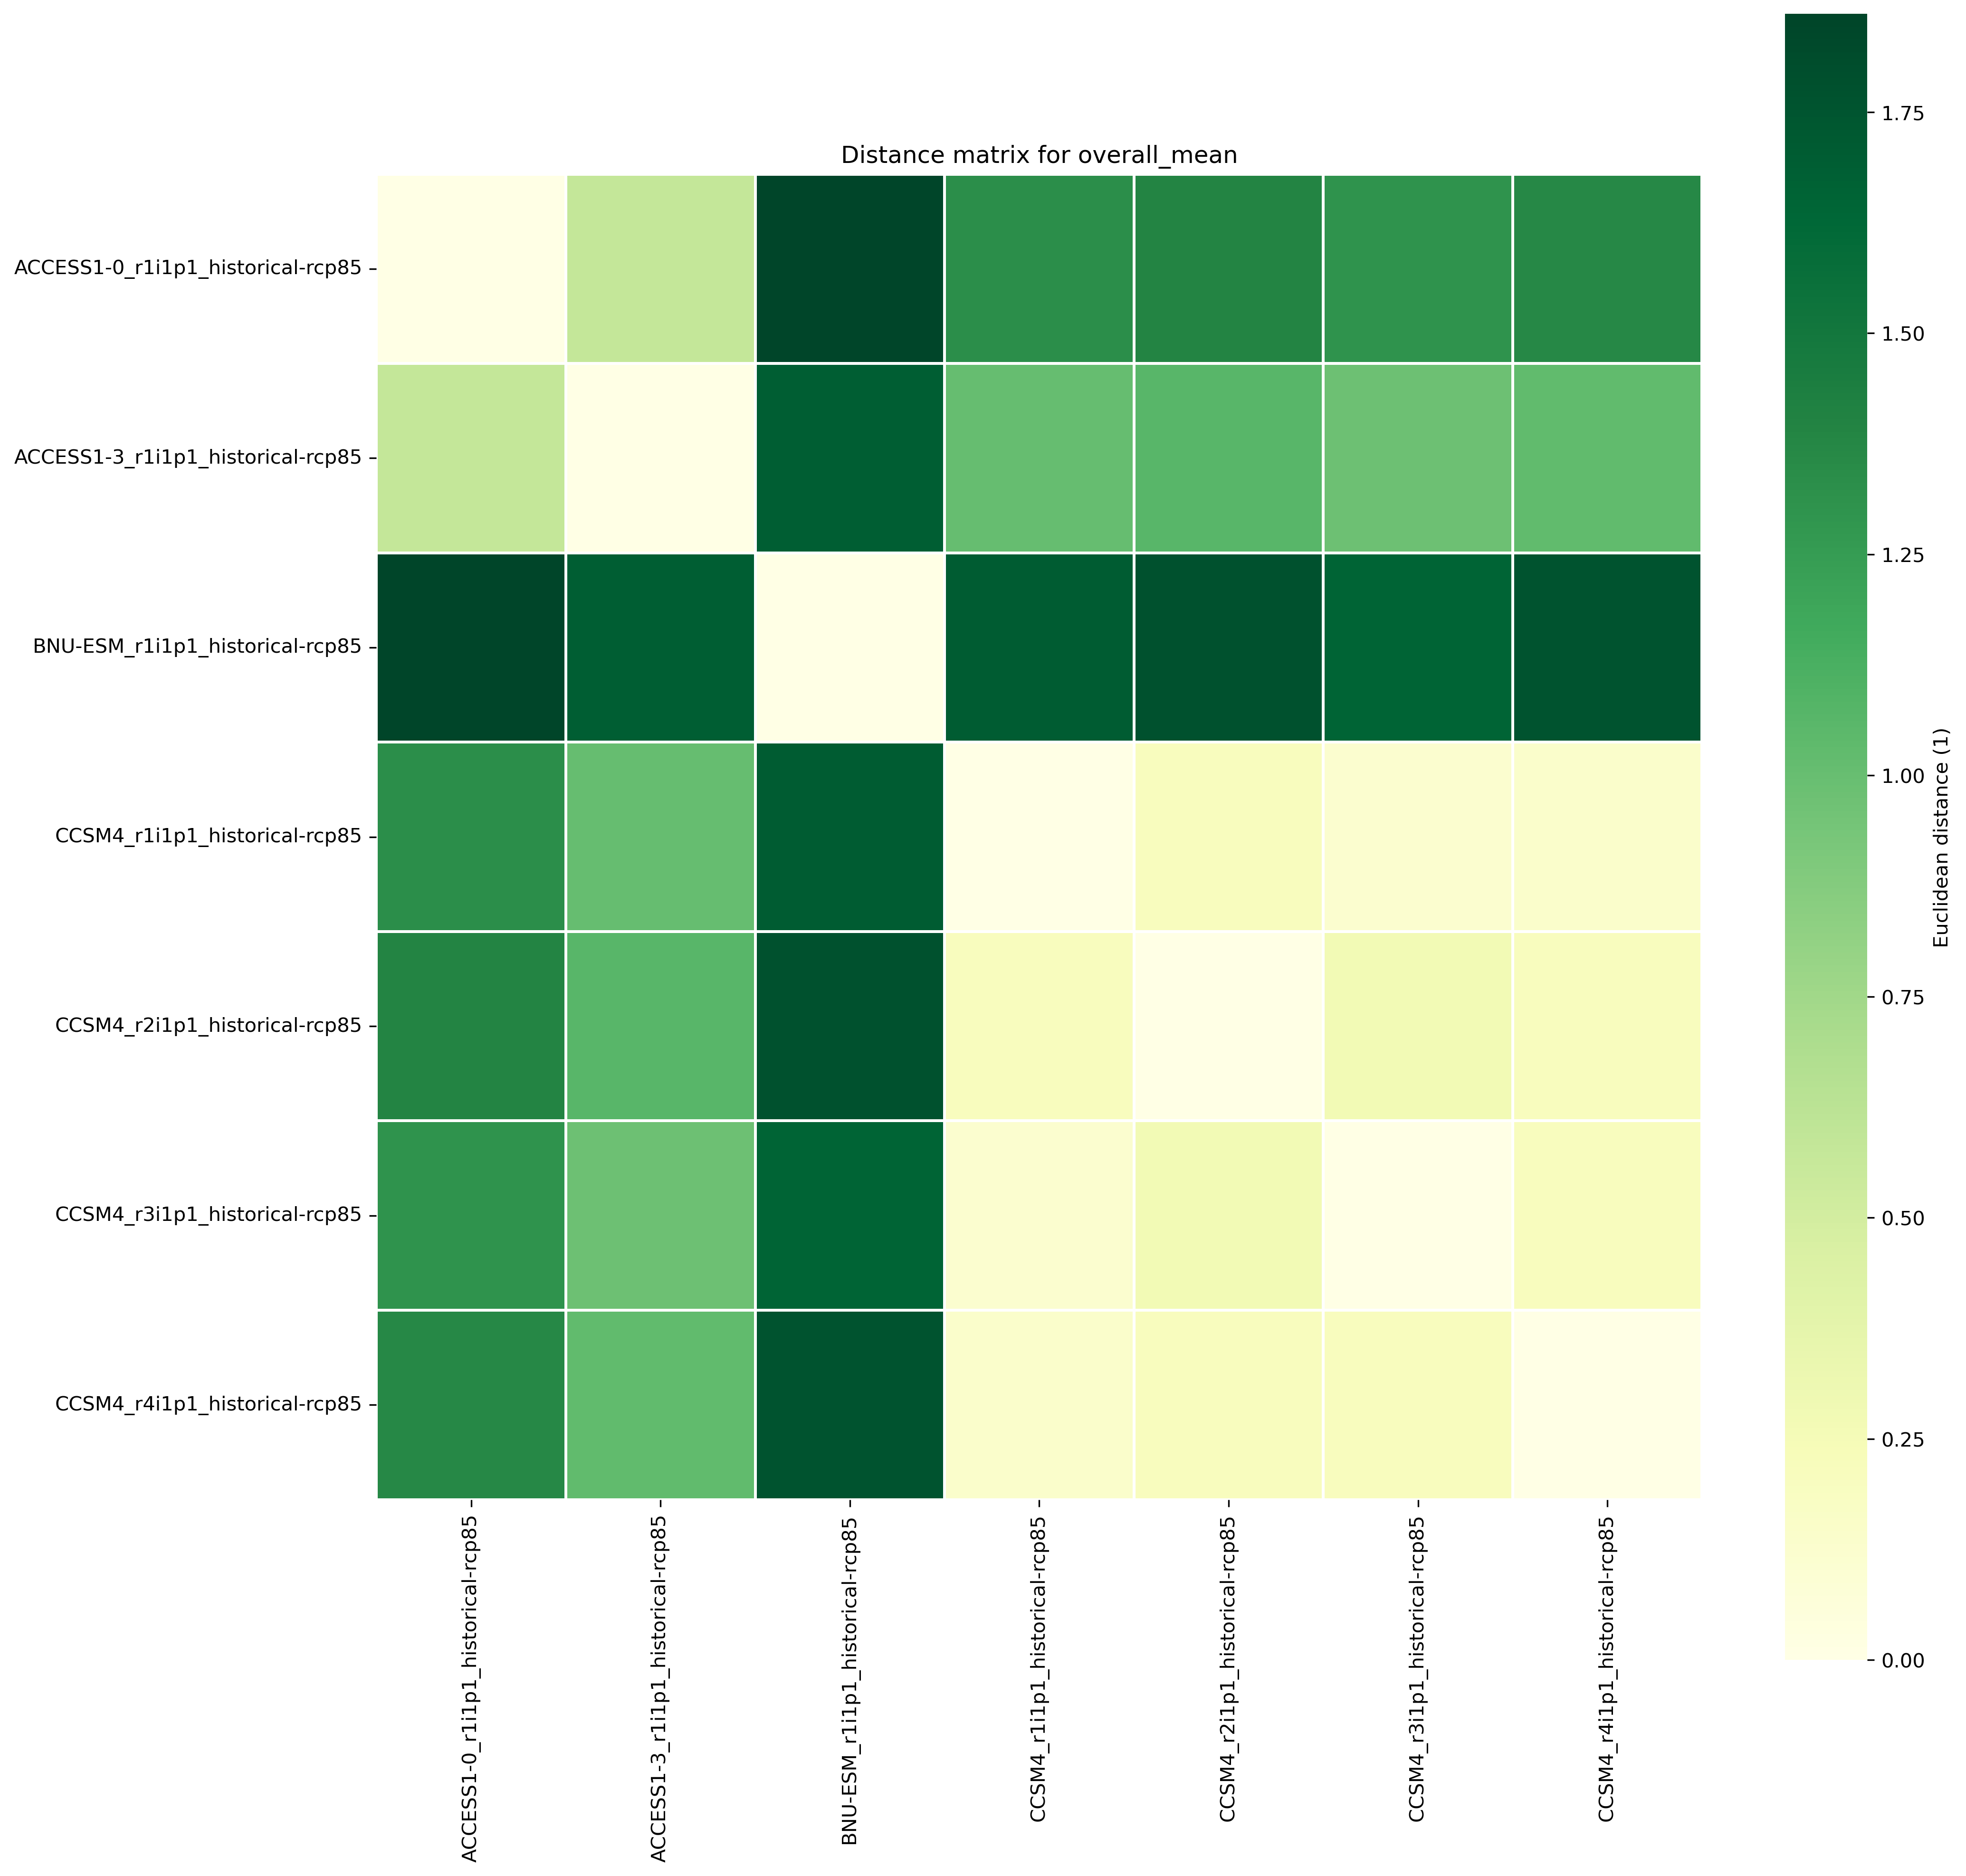

In [28]:
plots = [f for f in output['calculate_weights_climwip/climwip'] if isinstance(f, esmvaltool.recipe_output.ImageFile)]
plots[0]

ImageFile('temperature_change_difference_map.png')
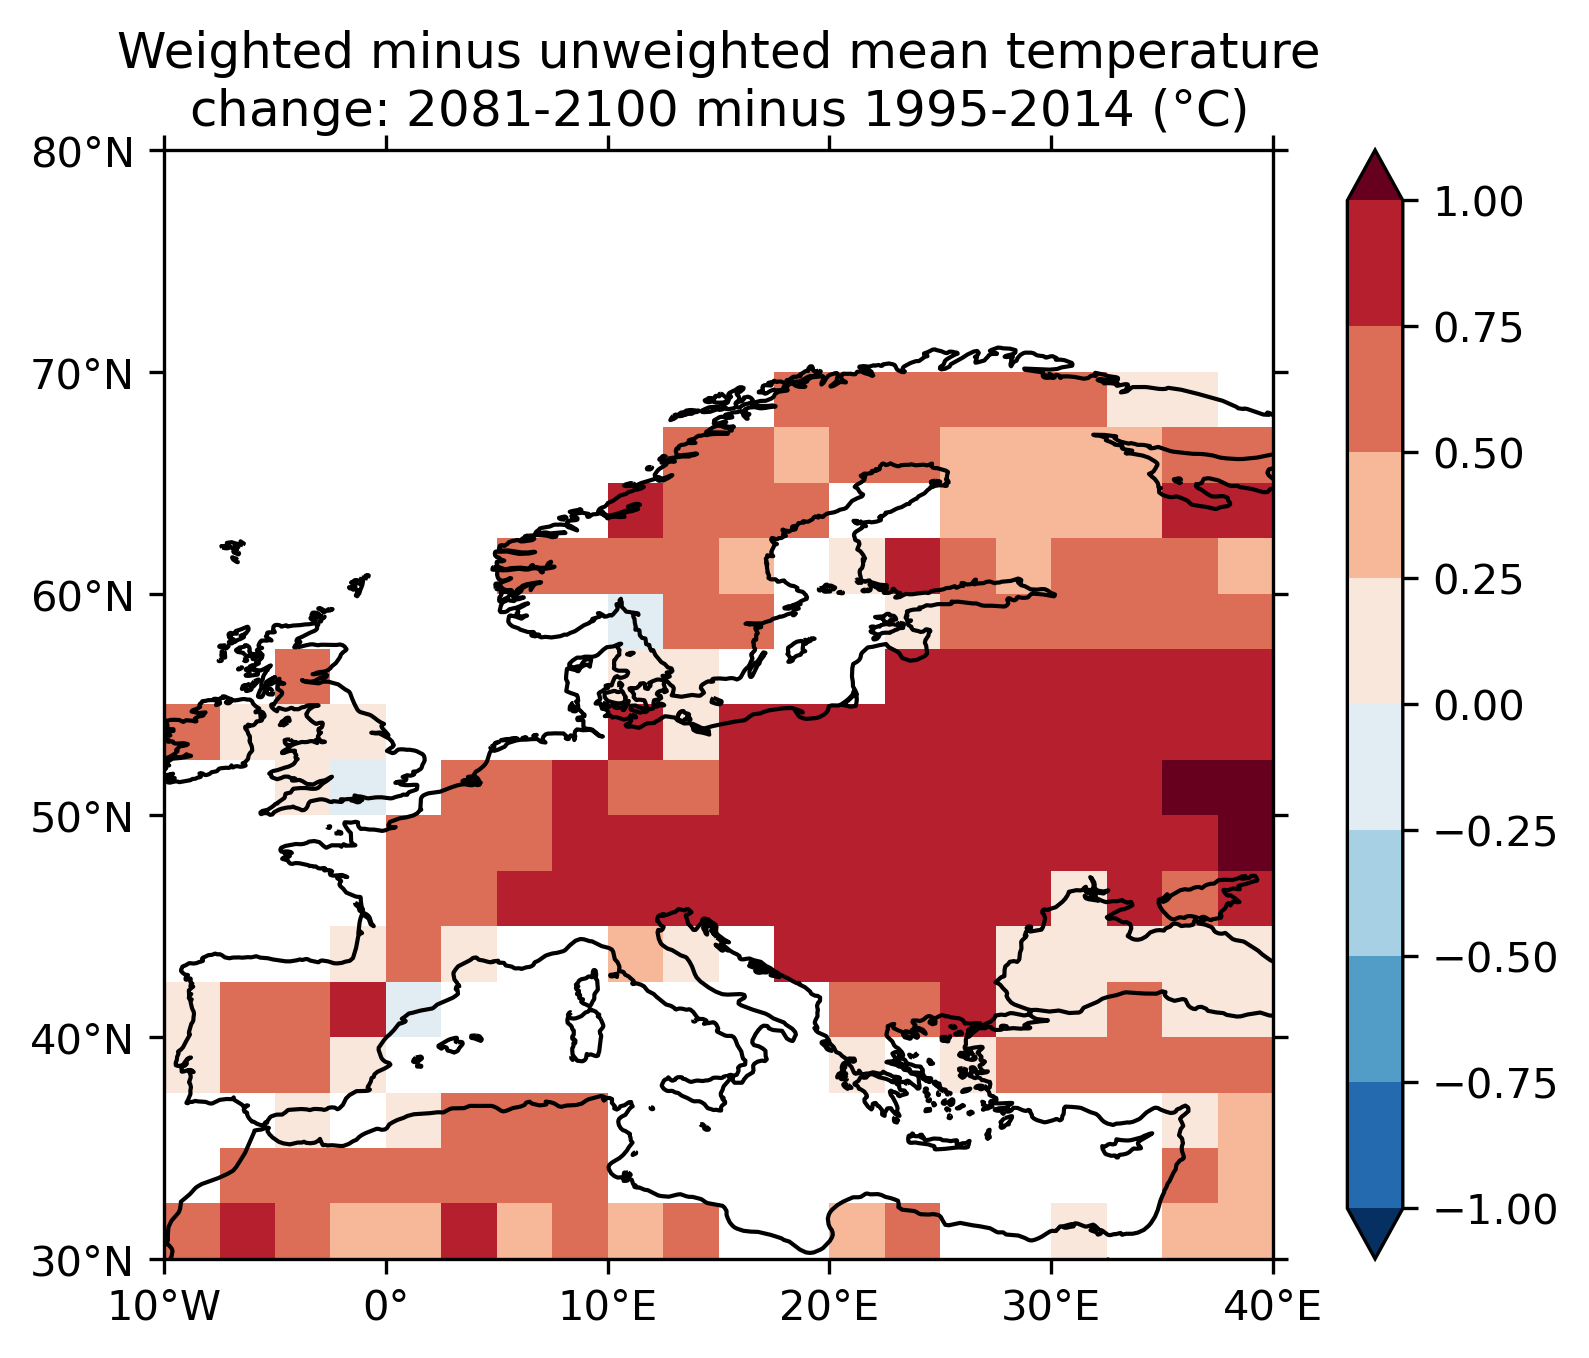

In [38]:
output['weighted_temperature_map/weighted_temperature_map'][0]

ImageFile('temperature_change_weighted_map.png')
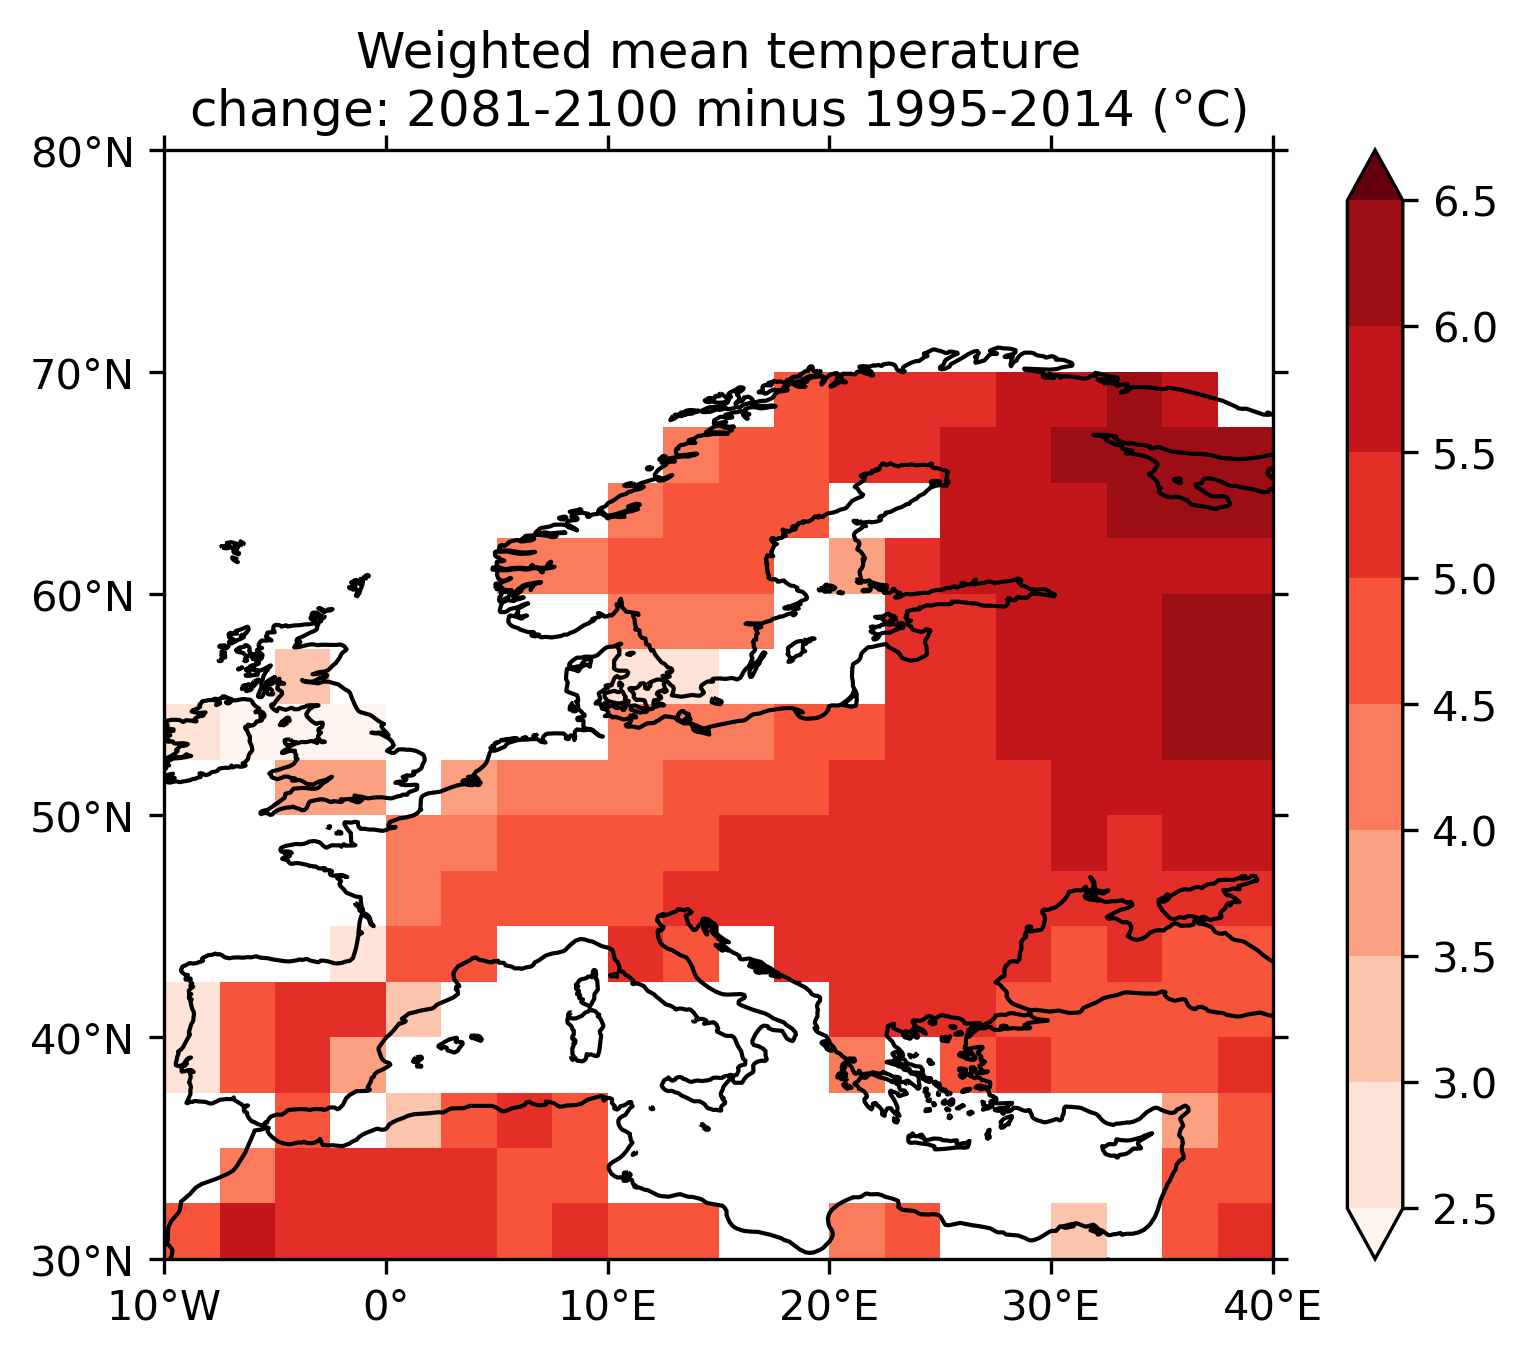

In [39]:
output['weighted_temperature_map/weighted_temperature_map'][1]

ImageFile('temperature_anomaly_graph.png')
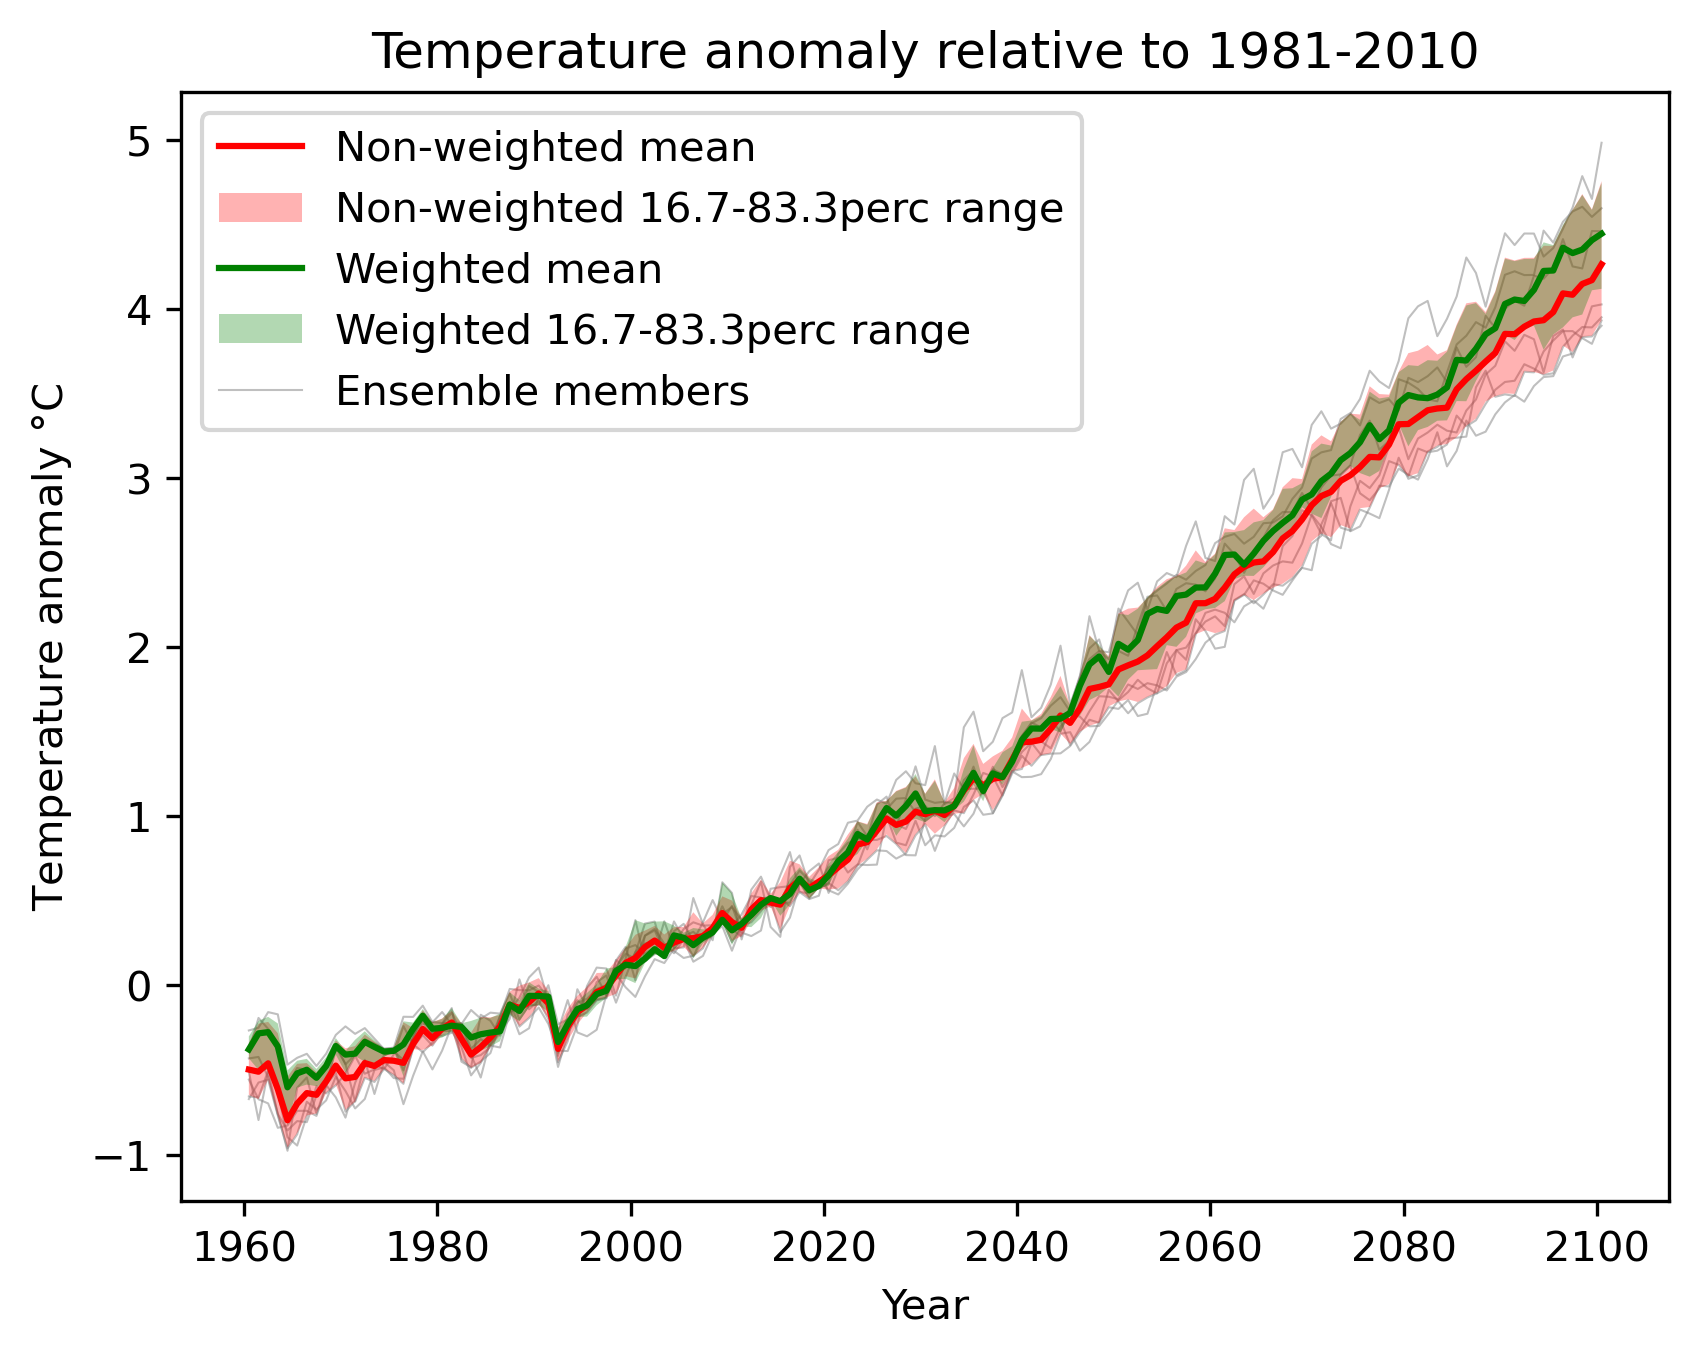

In [40]:
output['weighted_temperature_graph/weighted_temperature_graph'][0]

The data used to create the plots is also available:

In [35]:
data_files = [f for f in output['weighted_temperature_map/weighted_temperature_map'] if isinstance(f, esmvaltool.recipe_output.DataFile)]
data_files

[DataFile('temperature_change_difference_map.nc'),
 DataFile('temperature_change_weighted_map.nc')]

If the output is a dataset, you can load it with `xarray` or `iris`. In this way, you can immediately continue to work with the (pre-)processed data in your notebook.

In [36]:
xrds = data_files[0].load_xarray()
xrds

<xarray.Dataset>
Dimensions:                        (lat: 16, lon: 20)
Coordinates:
  * lat                            (lat) float64 31.25 33.75 ... 66.25 68.75
  * lon                            (lon) float64 -8.75 -6.25 ... 36.25 38.75
Data variables:
    __xarray_dataarray_variable__  (lat, lon) float64 0.7382 0.8912 ... nan
Attributes:
    software:  Created with ESMValTool v2.9.0
    caption:   Weighted minus unweighted mean temperature\nchange: 2081-2100 ...

## More information and contact details

For more information on all available recipes, visit the [ESMValTool documentation](https://docs.esmvaltool.org/en/latest/recipes/index.html). If this presentation has sparked your interest, you are welcome to join one of our [online monthly meetings](https://docs.esmvaltool.org/en/latest/introduction.html#monthly-meetings) (open to anyone with an interest in ESMValTool), [mailing list](https://docs.esmvaltool.org/en/latest/introduction.html#user-mailing-list), or join us on [GitHub](https://github.com/esmvalgroup/esmvaltool/discussions).
